## Job Interview using Kaggle Competetion of Pneumothorax

- **Author:** Yonghui Li (Aries)
- **Email :** Lyh710@gmail.com
- **Mobile:** 0472 827 179

Note the purpose of this work is **not** for the Kaggle competetion at all, but for a job interview. The aim is to use the Kaggle problem as an example to demonstrate our overall capability as best as we can. All is done within very limited time, and it is a one-off best attempt.

## Git repo: https://github.com/lyh710/kaggle.pneumothorax
- Instead of reviewing this notebook offline, I recommend to review via the corresponding Github repo I created above, which should provide a more robust experience.
- The repo is setup as **public**, but will probably be switched back to **private** after it served the purpose.

## Instruction provided by the recruiter:
1.	Access and download the dataset from the Kaggle competition for Pneunomthorax detection: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview   
2.	Perform appropriate exploratory data analysis and visualisation 
3.	Build a best-effort algorithm to detect a visual signal for Pneunomthorax as per the competition evaluation metric 
4.	Generate appropriate graphs / results table to assess model performance 
5.	Make a baseline submission to the late submission pool 
6.	Discuss shortcomings and the improvements you would make to the dataset, evaluation metrics and algorithm 

## Acknowledgement
To my wife, for keeping the kids occupied and entertained during weekend, so that I can pull this off.

## Disclaim
- I spent approximately **xx** hours for this piece of work, scattered from 2020-Aug-28th till yyth.
- This is an out-dated Kaggle competetion, which comes with lots of code snippets as well as comments shared by other players or by Kaggle itself. Whenever such information is leveraged, it will be noted in the notebook for clarity. 

## --------------------------------------------------------------------------------------------------------------------------------

## Dev Env Setup
https://github.com/lyh710/kaggle.pneumothorax/tree/master/dnn_gpu_setup_test

- **conda_dnn_gpu_setup.bat**: this piece of work is developed via my personal Dell laptop (AlienWare) with Windows10-Home OS (64bit, 16GB memory). Therefore, the setup batch script is in Win-DOS flavour. But the logic can be transferred to Linux/Mac situation easily. We lock in below python packages as initial env setup:
    - Python=3.7.6
    - Tensorflow-gpu=2.0.0
    - PyTorch=1.4.0
    - numpy 
    - pandas 
    - seaborn 
    - sklearn 
    - progressbar2 
    - **pydicom**
    
- I have the NVIDIA GeForce GTX 1080 (Max-Q 8GB) with my machine, which provides some GPU power for this work. But for formal project, a much more decent computing platform with better GPU capability will be required.For example, the low GPU memory of my machine stops me from using bigger batch size. The fact that I am running this script on a personal laptop, stops me from doing decent number of epochs for training.

**Call out**
- Conda virtual env is the minimum bar for reproducing the work. It may be good enough for a Kaggle competetion or job interview, but may not serve the purpose of formal project. For example, a Docker container to wrap up the conda env could provide more stable and ready to ship model performance, particularly when we may be transiting what we developed here using windows OS to a different OS env, such as Linux/Mac.For production/commerical purpose, we will be operating on cloud or cluster env, proper dev env setup and tesitng will be required, so that model performance can be expected the same, when running on different hard/soft-ware. 

- **DICOM** is the international standard/protocl for medical imaging communication.The data provided in this Kaggle competetion is a relatively simplified scenario, that they all come from the same study/manufacture. Things are expected to be much more complicated in real world, and the DCM images may come from different places, scanned by different machines of different manufacture. Whether the open source package, **pydicom** in this case, can successfully and robustly convert all these DCM images correctly, should be properly tested.

## --------------------------------------------------------------------------------------------------------------------------------

## Packages Loading

In [70]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil, pydicom

import pandas as pd

import numpy as np
np.random.seed(7) # set random seed for reproducibility

import matplotlib.pyplot as plt

from mask_functions import *

## --------------------------------------------------------------------------------------------------------------------------------

## Data Explore

- Due to this is an out-dated competetion, the dataset is no longer available via the Cloud Healthcare API. We downloaded via: https://www.kaggle.com/seesee/siim-train-test, which is provided by others.
- The downloaded datasete has non-flatten folder structures for each train/test sample, which raised complication to our process. Therefore, we shall first clean up the folder structure. 

Note that, nesting/tree-like folder strucutre is common for **DICOM** data. Each layer/level of the folder indicates corresponding entity, such as "Patient", "Study", "Series", "Instance" etc. The naming of each folder level corresponds to each entity. This Kaggle example is actually giving us a simplified scenario, that there is only one instance for each Study/Series. While this enables us to simplify the folder structure to a much more flatten way, we may need to handle it differently in real world project. In other words, there is room to uplift what we do here regarding data preparation.

In [25]:
def getListOfDcmFiles(dirName):
    '''
    Input a directory (full path)
    Output: all the DICOM file within this directory and sub-folders
    It is done by recursive call of the function itself
    '''
    listOfFile = os.listdir(dirName)
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            if os.path.splitext(fullPath)[-1] == '.dcm':
                allFiles.append(fullPath)
                
    return allFiles

def cpDcmFiles(src_dn, trgDir):
    '''
    Copy all DICOM files from source directory (including sub-folders) to target directory
    '''
    assert os.path.isdir(src_dn)
    assert os.path.isdir(trgDir)
    
    allFiles = getListOfFiles(src_dn)
    
    for fn in allFiles:
        trg_fn = os.path.join(trgDir, os.path.basename(os.path.normpath(fn)))
        if os.path.exists(trg_fn):
            os.remove(trg_fn)
        shutil.copy(fn, trg_fn)
        

src_dn   = os.path.join(os.getcwd(),'data', 'siim', 'dicom-images-train')
trg_dn   = os.path.join(os.getcwd(),'data', 'train')
cpDcmFiles(src_dn, trg_dn)
print('There are {} DICOM files in train'.format(len(os.listdir(trg_dn))))

src_dn   = os.path.join(os.getcwd(),'data', 'siim', 'dicom-images-test')
trg_dn   = os.path.join(os.getcwd(),'data', 'test')
cpDcmFiles(src_dn, trg_dn)
print('There are {} DICOM files in test'.format(len(os.listdir(trg_dn))))

There are 12089 DICOM files in train
There are 3205 DICOM files in test


## Label (mask) info

train-rle.csv

Introduction provided by Kaggle has confirmed the below:
- Given the DCM image ID, "-1" means **negative** sample
- Given the DCM image ID, run-length-encoded (RLE) means **positive** sample and the detail location (mask) of the pneumothorax 

In [22]:
# Quick peek of the label/mask spreadsheet

fn           = os.path.join(os.getcwd(),'data', 'train-rle.csv')
df_train_rle = pd.read_csv(fn)

print(df_train_rle.shape)
print(df_train_rle.dtypes)
print(len(df_train_rle['ImageId'].unique()))

df_train_rle.head(2).values

(12954, 2)
ImageId           object
 EncodedPixels    object
dtype: object
12047


array([['1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819', '-1'],
       ['1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800',
        '557374 2 1015 8 1009 14 1002 20 997 26 990 32 985 38 980 42 981 42 979 43 978 45 976 47 964 59 956 66 925 98 922 101 917 106 916 106 916 107 914 109 909 113 907 116 904 118 903 120 902 120 902 121 900 122 899 124 898 124 898 125 897 125 898 125 896 126 895 127 895 128 895 128 895 128 894 128 895 128 895 128 895 128 895 128 895 128 894 130 893 130 893 130 893 130 893 129 894 129 894 129 894 129 895 127 897 126 898 126 898 125 898 126 898 125 899 125 899 125 899 124 900 124 900 125 899 125 899 125 899 125 899 126 898 127 897 128 897 128 896 129 895 130 894 132 892 133 891 134 890 136 888 137 888 137 887 139 885 140 884 141 884 141 883 142 882 143 881 145 879 146 879 147 878 147 877 149 876 150 874 153 872 153 871 154 871 154 870 155 870 154 870 154 870 154 871 153 871 154 871 154 870 154 871 154 870 155 869 155 870 155 869 155 869 155 869 15

### Two observations can be seen from inspecting the spreadsheet:
- There is whitespace character within the column name (EncodedPixels), which is better addressed upfront before proceeding
- The count of unique DCM image IDs in the spreadsheet is less than the total count of records, which is clarified by Kaggle that some training images have multiple annotations.

In [39]:
# Rename the columns by strip space

for col in df_train_rle.columns:
    df_train_rle.rename(columns={col: col.strip()}, inplace=True)
    
print(df_train_rle.dtypes)

ImageId          object
EncodedPixels    object
dtype: object


In [41]:
# Show DCM image ID that have multiple EncodedPixels info

df_cnt = df_train_rle.groupby('ImageId').agg(['count'])
dup_dcm_ids = df_cnt[df_cnt['EncodedPixels']['count']>1].index
print('There are {} DCM IDs with more multiple annotations '.format(len(dup_dcm_ids)))
dup_dcm_ids

There are 624 DCM IDs with more multiple annotations 


Index(['1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487',
       '1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942',
       '1.2.276.0.7230010.3.1.4.8323329.10034.1517875221.47394',
       '1.2.276.0.7230010.3.1.4.8323329.10050.1517875221.763035',
       '1.2.276.0.7230010.3.1.4.8323329.10060.1517875221.792744',
       '1.2.276.0.7230010.3.1.4.8323329.10078.1517875221.860801',
       '1.2.276.0.7230010.3.1.4.8323329.10088.1517875221.907774',
       '1.2.276.0.7230010.3.1.4.8323329.10093.1517875221.950467',
       '1.2.276.0.7230010.3.1.4.8323329.10098.1517875222.57431',
       '1.2.276.0.7230010.3.1.4.8323329.10099.1517875222.78541',
       ...
       '1.2.276.0.7230010.3.1.4.8323329.5704.1517875189.675934',
       '1.2.276.0.7230010.3.1.4.8323329.5710.1517875189.709115',
       '1.2.276.0.7230010.3.1.4.8323329.5746.1517875190.97136',
       '1.2.276.0.7230010.3.1.4.8323329.5747.1517875190.107803',
       '1.2.276.0.7230010.3.1.4.8323329.5749.1517875190.142037',
       '

In [42]:
# One example of multiple annotation

df_train_rle[df_train_rle['ImageId']==dup_dcm_ids[0]]

,ImageId,EncodedPixels
5450,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...
9058,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,891504 5 1018 8 1015 10 1013 12 1011 14 1009 1...
10109,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,659506 1 1022 5 1018 6 1017 8 1014 10 1012 12 ...


## Do we have all the DCM training images mentioned in the spreadsheet?

In [46]:
miss_train = []
for x in df_train_rle['ImageId'].unique():
    fn = os.path.join(os.getcwd(), 'data', 'train', x+'.dcm')
    if not os.path.exists(fn):
        miss_train.append(fn)

print('There are {} DCM image missed from the spreadsheet'.format(len(miss_train)))

There are 0 DCM image missed from the spreadsheet


We have **all** the DCM training samples mentioned in the spreadsheet, good to proceed

### View some random DCM images

In [59]:
# Below 2 utils are provided by https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
# The original code snippet has a bug around the "fn", which I fixed accordingly to make it work
def show_dcm_info(fn, dataset):
    print("Filename.........:", fn)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Filename.........: D:\Git\kaggle.pneumothorax\data\train\1.2.276.0.7230010.3.1.4.8323329.392.1517875162.735831.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: e6b5e5bb-1332-47af-b57e-2c2fcc76521f, 
Patient id..........: e6b5e5bb-1332-47af-b57e-2c2fcc76521f
Patient's Age.......: 54
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 164202 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


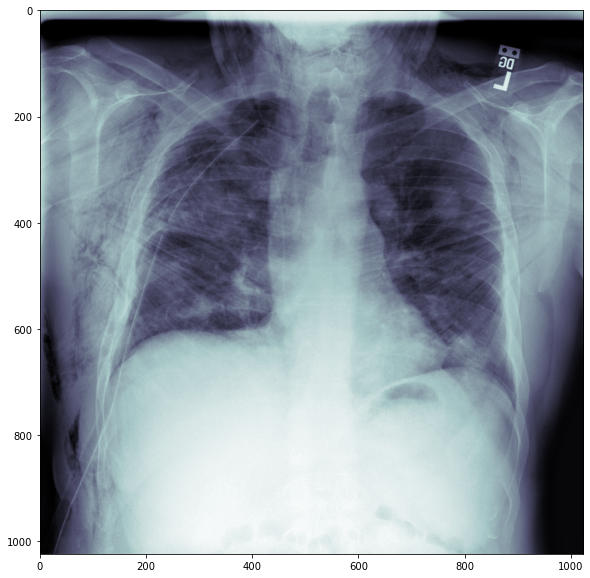

In [69]:
# one random DCM image to view
dcm_id  =  np.random.choice(df_train_rle['ImageId'].unique())
fn      = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
dataset = pydicom.dcmread(fn)
show_dcm_info(fn, dataset)
plot_pixel_array(dataset)

**Call out** 

We shall pay cautious regarding the "Left/Right" of the DCM image. Human body is highly symmetric (maybe less so regarding chest, but very much so regarding brain). The recommended practice is to have "marker" on designated side of the subject when scanning, so that we will have golden truth regarding "Left/Right". This can be achieved by: 
1. Small cube of water/oil/plastic is usual way. 
2. If certain subject has obvious marker on their body (known to have tumour in the left lung from previous diagnosis for example), then these subjects can serve the purpose of "Left/Right" check during our DCM data processing. 

We don't need to do this for every instance. As long as the scan is done by the same machine on the same site with the same setup, a few samples of such practice should be good enough. We only need to repeat such procedure, when it is a multi-site or multi-machine projects, or machine setup (hard/soft-ware) been modified (upgraded) during project.

We can observe a "L" marker within each DCM image, but the style of it varies across samples, which indicates the possibility of these samples may be coming from different sites (hospitals), scanned by different machines. It further highlights the need of the ground-truth check of "Left/Right" if this is one single project of us.

### Over lay with the Label/Mask of pneumothorax 

- mask_functions.py comes with the dataset, which I assume either provided by Kaggle, or by who prepared the dataset
- A transpose seems necessary for correct position of the mask over the given DCM image, which is a tip shared by other player

1.2.276.0.7230010.3.1.4.8323329.3843.1517875179.736412
230817 1 1019 7 998 27 987 38 979 45 972 53 967 57 963 61 961 62 960 62 959 62 958 61 959 61 959 63 958 64 958 65 957 65 957 65 956 66 954 66 954 65 956 65 957 64 959 63 959 62 961 60 962 58 963 57 965 55 967 55 968 54 968 54 968 54 968 54 967 54 968 53 969 52 971 51 972 50 972 50 972 49 972 49 973 48 973 48 974 48 974 48 975 47 975 48 974 48 974 48 974 49 973 49 973 48 975 47 975 47 976 47 975 46 975 47 976 46 976 46 977 45 978 45 977 46 977 46 976 46 976 47 975 47 976 46 977 45 977 46 977 45 977 46 977 45 978 44 978 44 979 44 979 43 980 43 981 42 980 42 981 41 981 42 981 41 982 41 982 40 984 39 984 39 984 37 986 37 986 36 987 35 988 35 988 35 988 34 989 34 989 33 991 32 991 32 991 32 992 31 992 31 993 30 993 31 992 31 992 31 991 32 991 33 990 33 990 33 991 33 990 33 991 33 990 33 990 33 991 33 990 33 991 32 990 34 989 34 989 34 989 34 989 34 989 34 989 35 988 35 988 35 988 36 987 36 987 37 985 38 985 39 984 39 984 40 983 40 984 4

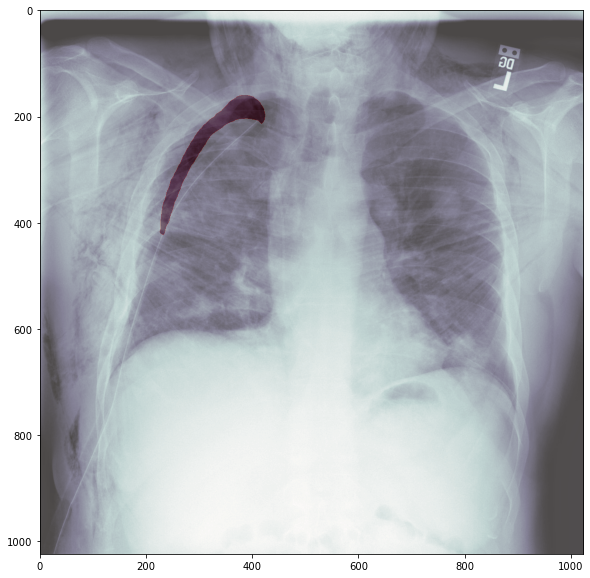

195274 4 1015 10 1011 14 1006 19 1003 21 1001 23 999 25 997 27 994 29 993 30 991 32 988 35 988 35 986 38 983 40 983 39 983 40 982 41 982 41 982 41 983 40 984 39 984 39 985 38 986 37 986 37 987 36 987 35 989 34 990 33 990 33 991 32 991 33 991 32 991 32 992 30 994 29 994 29 995 28 995 28 996 27 996 27 997 27 997 26 997 26 998 26 997 26 997 26 998 26 997 26 998 26 997 26 998 25 998 26 997 26 998 26 997 27 997 26 997 26 998 26 997 26 998 26 997 26 998 26 997 26 997 27 997 26 997 27 997 26 997 27 997 26 998 26 998 25 998 25 999 25 998 25 999 25 998 25 999 25 999 25 998 25 999 25 999 25 999 24 1000 24 999 25 999 24 1000 24 1000 24 999 24 1000 24 1000 23 1000 24 1000 24 1000 24 1000 24 999 25 999 24 1000 24 1000 24 999 25 999 24 1000 24 1000 24 1000 24 999 25 999 24 1000 24 999 25 999 25 999 24 1000 24 1000 24 999 24 1000 24 1000 24 1000 23 1001 23 1001 23 1001 22 1001 23 1001 23 1001 22 1002 22 1002 22 1002 21 1002 22 1002 22 1002 21 1003 21 1003 21 1003 21 1002 22 1002 22 1002 21 1003 21 10

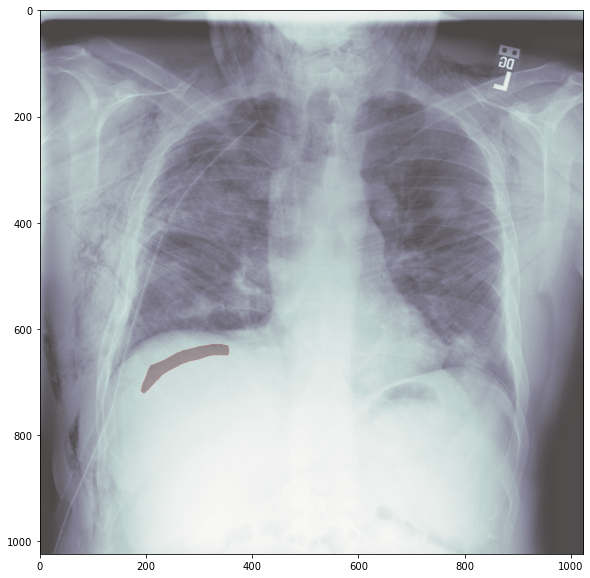

In [140]:
# We purposely want to view the training sample with multiple pneumothorax, which is expected to be a more complicated scenario

dcm_id  =  np.random.choice(dup_dcm_ids)
# dcm_id = '1.2.276.0.7230010.3.1.4.8323329.32714.1517875161.932531' 
print(dcm_id)
dcm_fn  = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
dataset = pydicom.dcmread(fn)

rles    = df_train_rle[df_train_rle['ImageId']==dcm_id]['EncodedPixels']
for rle in rles:
    print(rle)
    mask = rle2mask(rle, 1024, 1024).T  # Transpose is suggested by Kaggle, which seems necessary by eye-balling
    
    plt.figure(figsize=(10,10))
    
    # DCM
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    
    # mask
    plt.imshow(mask, alpha=0.3, cmap="Reds")
    
    plt.show()

**Call out**

I can **NOT** verify whether the Label/Mask is correctly overlay on the DCM image, simply because I don't have the expertise regarding  pneumothorax. In other words, I can **NOT** verify whether the util function as well as the transpose tip provided by Kaggle (or other player) is indeed correct.

The best I can tell, is the transpose **seems** necessary, because if I turned it off, the mask will be completely off the lung area.

This clearly highlight the need for ML/AI practiciationer to collaborate with clinical/heath-care expertise (radiologist) in the first place.

The **worst** case of this issue, is I may have messed up the label/mask layout completely, which naturally means the resulted model will be **useless**.

We will proceed for now, with the sole purpose being to demonstrate out thinking and attempt to provide an end-to-end piece of work as much as possible.

## --------------------------------------------------------------------------------------------------------------------------------